<a href="https://colab.research.google.com/github/ivaibhavjindal/DIC/blob/master/Denoising_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Filters Applied 
* Gaussian
* Bilateral
* Total variation filter
* Wavelet denoising filter
* Shift invariant wavelet
* Anisotropic diffusion
* Non Local Means(NLM) 
* Block-matching and 3D filtering(BM3D)

The 3 top denoising algorithms for CT denoising are 
NLM, Bilateral, block-match and 3D filtering (BM3D),
Total variation (TV) also works great. 
Bilateral is slow and it probably works fine except it takes too much 
time to experiment with parameters.

In [ ]:
import os

# Importing images
try:
  os.rmdir('/images')
  os.mkdir('/images')
  os.chdir('/images/')
  print(os.getcwd())
except:
  print("Cannot Change Current Working Directory")

/images


In [ ]:
from google.colab import files
images = files.upload()

Saving clean_img.tif to clean_img.tif
Saving noisy_img.tif to noisy_img.tif


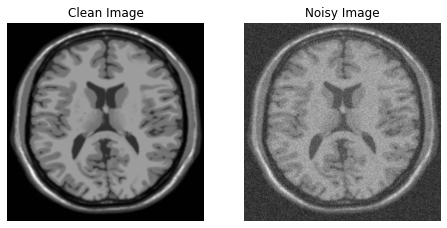

In [ ]:
from skimage import img_as_float
from skimage import io
from matplotlib import pyplot as plt

clean_img_name = 'clean_img.tif'
noisy_img_name = 'noisy_img.tif'

clean_img = img_as_float(io.imread(clean_img_name))
noisy_img = img_as_float(io.imread(noisy_img_name))

#Function To display noisy, clean and filtered image
def show_images(filter_img=0, filter_name=0):

  plt.figure(figsize=(12, 12))

  plt.subplot(131)
  plt.imshow(clean_img, cmap='gray') 
  plt.title('Clean Image')
  plt.axis('Off')

  plt.subplot(132)
  plt.imshow(noisy_img, cmap='gray')
  plt.title('Noisy Image')
  plt.axis('Off')

  if(filter_name):
    plt.subplot(133)
    plt.imshow(filter_img, cmap='gray')
    plt.title(f'{filter_name} Filter')
    plt.axis('Off')

  plt.show()

show_images()

Peak signal-to-noise ratio (PSNR) is the ratio between the maximum possible power of an image and the power of corrupting noise that affects the quality of its representation. To estimate the PSNR of an image, it is necessary to compare that image to an ideal clean image with the maximum possible power.

**PSNR is most commonly used to estimate the efficiency of compressors, filters, etc. The larger the value of PSNR, the more efficient is a corresponding compression or filter method.**

Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/

In [ ]:
# Installations
!pip install bm3d
!pip install medpy


In [ ]:
# Imports

from skimage import img_as_float
from skimage.metrics import peak_signal_noise_ratio
from matplotlib import pyplot as plt
from skimage import io
from scipy import ndimage as nd
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, cycle_spin)
import cv2
from medpy.filter.smoothing import anisotropic_diffusion

import bm3d
import numpy as np

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float

#Need to convert to float as we will be doing math on the array
#Also, most skimage functions need float numbers

noise_psnr = peak_signal_noise_ratio(clean_img, noisy_img)

     |████████████████████████████████| 153kB 3.4MB/s 
     |████████████████████████████████| 42.5MB 102kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753435 sha256=88d757fbf19781444e56182e6c07de423ab2d7735911073d8c334990a7553c21
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy
PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.112001291081445


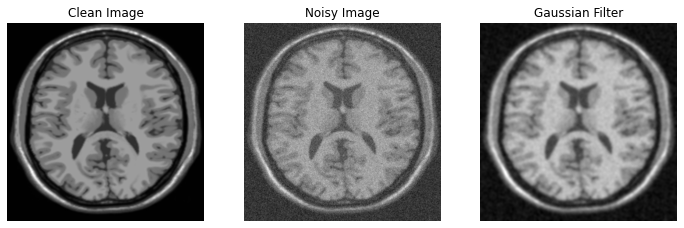

In [ ]:
#Gaussian

gaussian_img = nd.gaussian_filter(noisy_img, sigma=5)

gaussian_cleaned_psnr = peak_signal_noise_ratio(clean_img, gaussian_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", gaussian_cleaned_psnr)

show_images(gaussian_img, 'Gaussian')

PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.23833582424291


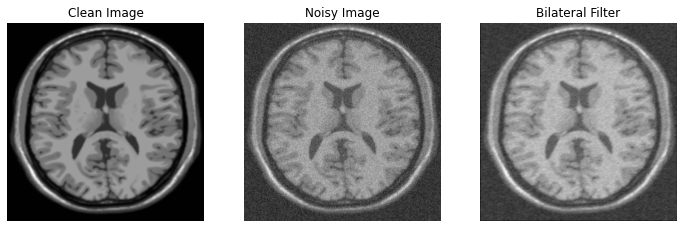

In [ ]:
# Bilateral
sigma_est = estimate_sigma(noisy_img, multichannel=True, average_sigmas=True)

bilateral_img = denoise_bilateral(noisy_img, sigma_spatial=1.5,multichannel=False)

bilateral_cleaned_psnr = peak_signal_noise_ratio(clean_img, bilateral_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", bilateral_cleaned_psnr)

show_images(bilateral_img, 'Bilateral')


PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.19161931394431


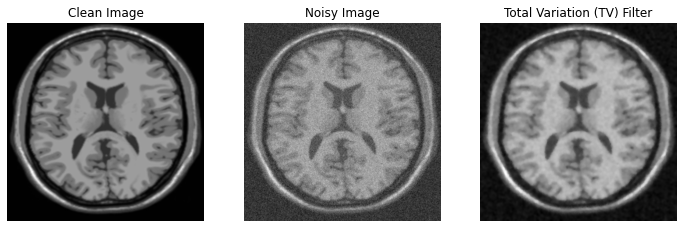

In [ ]:
# TV
TV_img = denoise_tv_chambolle(noisy_img, weight=0.3, multichannel=False)

TV_cleaned_psnr = peak_signal_noise_ratio(clean_img, TV_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", TV_cleaned_psnr)

show_images(TV_img, 'Total Variation (TV)')


PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.0525032515753


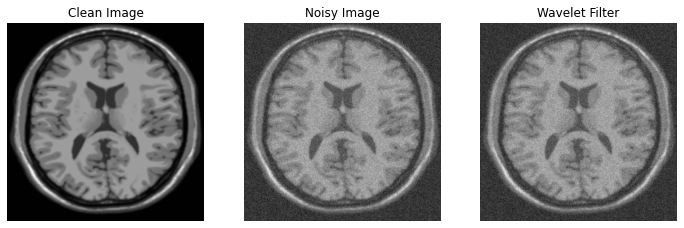

In [ ]:
# Wavelet
wavelet_smoothed_img = denoise_wavelet(noisy_img, multichannel=False,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

Wavelet_cleaned_psnr = peak_signal_noise_ratio(clean_img, wavelet_smoothed_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", Wavelet_cleaned_psnr)

show_images(wavelet_smoothed_img, 'Wavelet Smoothed')

PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.056279941818776


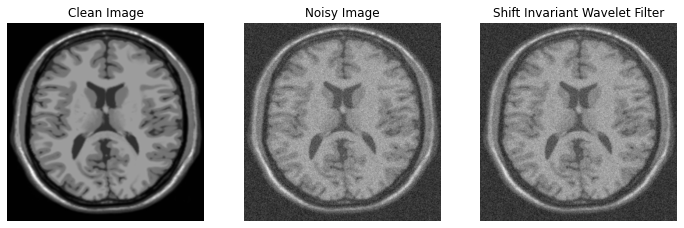

In [ ]:
# Shift Invariant Wavelet
# https://scikit-image.org/docs/dev/auto_examples/filters/plot_cycle_spinning.html

denoise_kwargs = dict(multichannel=False, wavelet='db1', method='BayesShrink',
                      rescale_sigma=True)

max_shifts = 3  #0, 1, 3, 5

shift_inv_wavelet_img = cycle_spin(noisy_img, func=denoise_wavelet, max_shifts = max_shifts,
                            func_kw=denoise_kwargs, multichannel=False)

shft_cleaned_psnr = peak_signal_noise_ratio(clean_img, shift_inv_wavelet_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", shft_cleaned_psnr)

show_images(shift_inv_wavelet_img, 'Shift Invariant Wavelet')

/usr/local/lib/python3.6/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.6/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  # This is added back by InteractiveShellApp.init_path()


PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.16316211540548


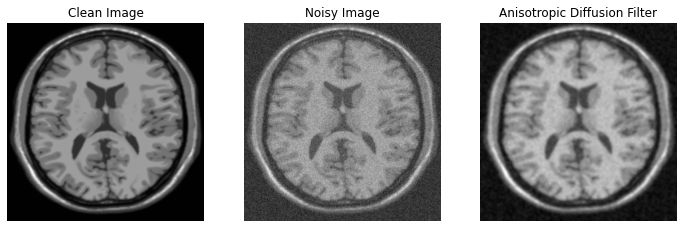

In [ ]:
#Anisotropic Diffusion

# niter= number of iterations
# kappa = Conduction coefficient (20 to 100)
# gamma = speed of diffusion (<=0.25)
# Option: Perona Malik equation 1 or 2. A value of 3 is for Turkey's biweight function 

aniso_filtered_img = anisotropic_diffusion(noisy_img, niter=50, kappa=50, gamma=0.2, option=2) 

anisotropic_cleaned_psnr = peak_signal_noise_ratio(clean_img, aniso_filtered_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", anisotropic_cleaned_psnr)

show_images(aniso_filtered_img, 'Anisotropic Diffusion')


     |████████████████████████████████| 8.4MB 3.1MB/s 
PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.373551020488097


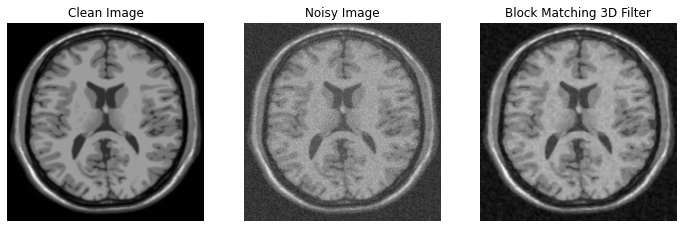

In [ ]:
# BM3D Block-matching and 3D filtering

BM3D_denoised_img = bm3d.bm3d(noisy_img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES)
#BM3D_denoised_img = bm3d.bm3d(noisy_img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

BM3D_cleaned_psnr = peak_signal_noise_ratio(clean_img, BM3D_denoised_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", BM3D_cleaned_psnr)

show_images(BM3D_denoised_img, 'Block Matching 3D')

PSNR of input noisy image =  17.03789982624248
PSNR of cleaned image =  17.03790009274298


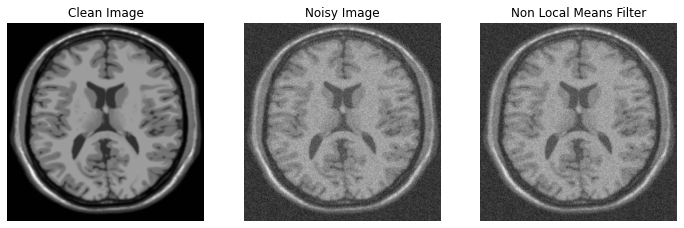

In [ ]:
# NLM

sigma_est = np.mean(estimate_sigma(noisy_img, multichannel=False))


NLM_img = denoise_nl_means(noisy_img, h=1.15 * sigma_est, fast_mode=True,
                               patch_size=9, patch_distance=5, multichannel=False)

NLM_skimg_cleaned_psnr = peak_signal_noise_ratio(clean_img, NLM_img)

print("PSNR of input noisy image = ", noise_psnr)
print("PSNR of cleaned image = ", NLM_skimg_cleaned_psnr)

show_images(NLM_img, 'Non Local Means')
